In [2]:

import numpy as np

import random

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")



In [3]:
#Tensorflow and Keras Libraries
import tensorflow as tf

from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import(
Conv2D, MaxPooling2D, Dense, Dropout,BatchNormalization, GlobalAveragePooling2D)

from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.optimizers import SGD, Adam



from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [4]:
#Data Split and Cross-Validation for Image Data
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


In [5]:

print(f'Tensorflow Version: {tf.__version__}')
print("GPU Available:", tf.config.list_physical_devices('GPU')[0])

Tensorflow Version: 2.7.0
GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [6]:
os.getcwd()

'C:\\Users\\DIKSHANT PATEL\\Kidney-Disease-Classification\\research'

In [7]:
os.chdir("./..")

In [8]:
os.getcwd()

'C:\\Users\\DIKSHANT PATEL\\Kidney-Disease-Classification'

In [9]:
data_csv_path = "artifacts/data_ingestion"
classes_dir_path = "artifacts/data_ingestion/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

In [10]:
classes = os.listdir(classes_dir_path)
classes

['Cyst', 'Normal', 'Stone', 'Tumor']

In [11]:
def make_df(classes,classes_dir_path):
    data = []
    for label in classes:
        folder_path = os.path.join(classes_dir_path,label)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            data.append((file_path, label))
            
    df = pd.DataFrame(data, columns=['file_path', 'label'])
    return df

In [12]:
df = make_df(classes, classes_dir_path)
df

,file_path,label
0,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Cyst
1,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Cyst
2,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Cyst
3,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Cyst
4,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Cyst
...,...,...
12441,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Tumor
12442,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Tumor
12443,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Tumor
12444,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Tumor


In [13]:
df.sample(12)

,file_path,label
9829,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Stone
11838,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Tumor
6035,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Normal
3326,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Cyst
3189,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Cyst
1530,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Cyst
239,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Cyst
5575,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Normal
4628,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Normal
1201,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Cyst


In [14]:
df['label'].value_counts()

label
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64

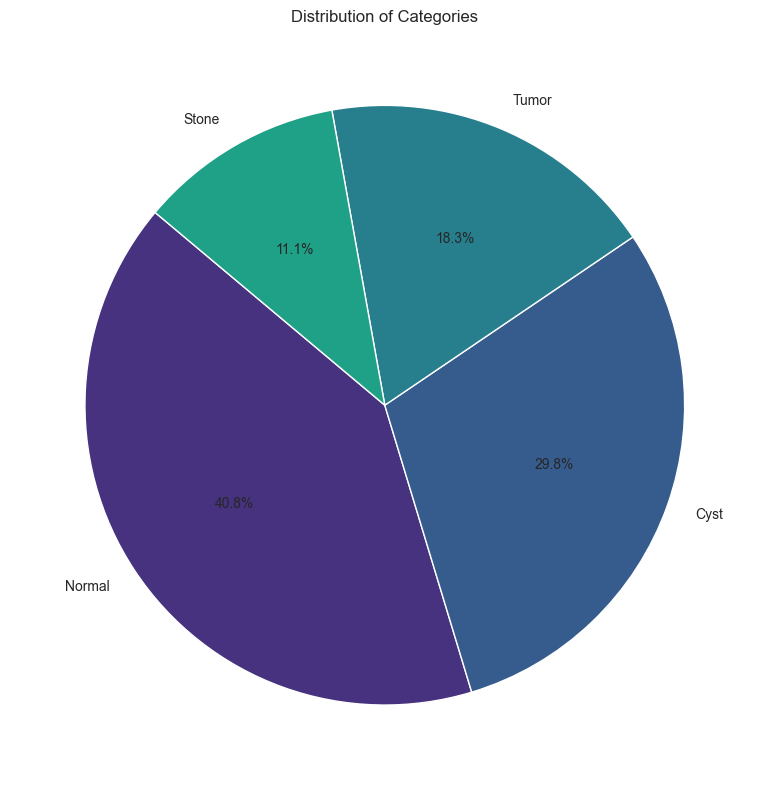

In [15]:
count = df["label"].value_counts()
palette = sns.color_palette("viridis")
colors = palette.as_hex()

plt.figure(figsize = (8,8))
plt.pie(count, labels=count.index, autopct= '%1.1f%%', startangle = 140, colors = colors)

plt.title("Distribution of Categories")
plt.tight_layout()
plt.show()

KeyError: 'percentage'

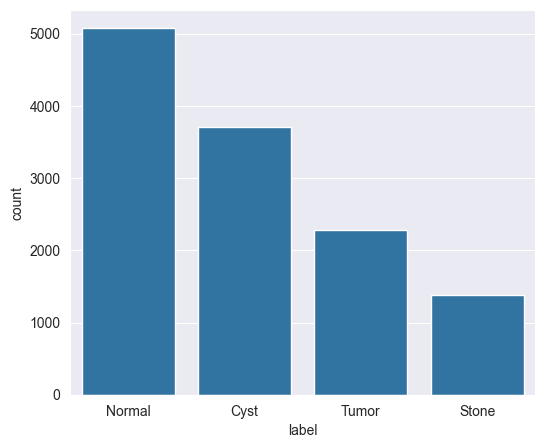

In [16]:
value_counts = df["label"].value_counts().reset_index()
value_counts.columns = ["label", "count"]
value_counts["Percentage"] = (value_counts["count"]/ value_counts["count"].sum() * 100).round(2)

plt.figure(figsize = (6,5))
ax = sns.barplot(data=value_counts, x='label', y='count')
for i, row in value_counts.iterrows():
    ax.text(i, row['count'], f"{row['percentage']}%", ha='center', va='bottom', fontsize=10, color='black')

plt.title("Class Distribution with Percentages")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

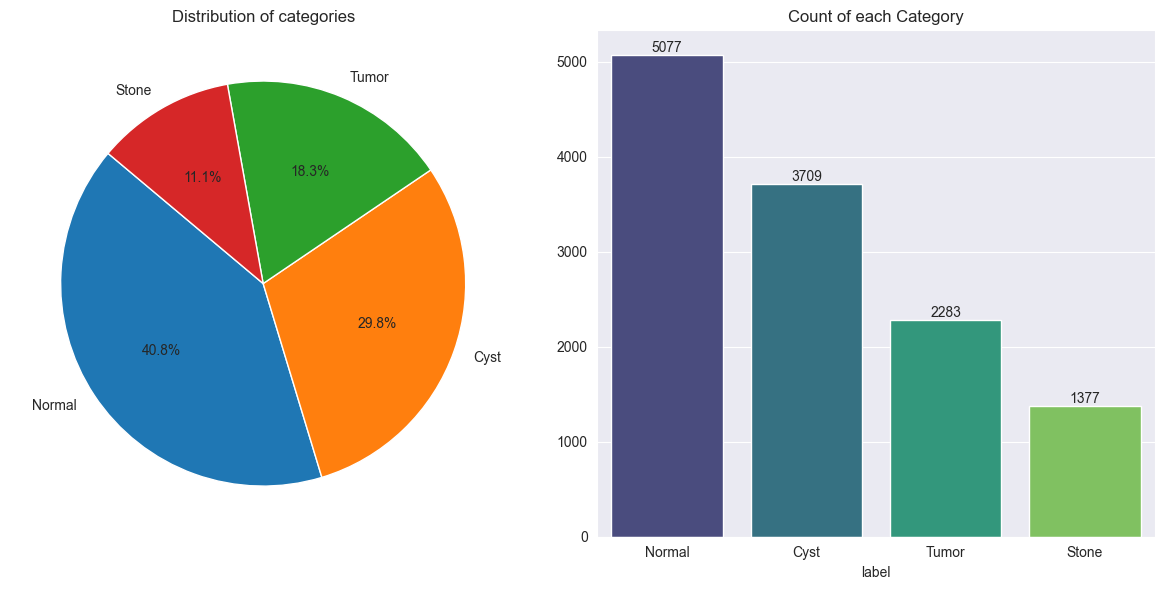

In [17]:
count = df['label'].value_counts()

fig, axs = plt.subplots(1, 2, figsize = (12,6), facecolor = 'white')

palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels = count.index, autopct = '%1.1f%%', startangle = 140)
axs[0].set_title('Distribution of categories')

sns.barplot(x=count.index, y=count.values, ax = axs[1], palette = 'viridis')
axs[1].set_title('Count of each Category')

for i, val in enumerate(count.values):
    axs[1].text(i, val, str(val), ha='center', va='bottom')
    
plt.tight_layout()

plt.show()

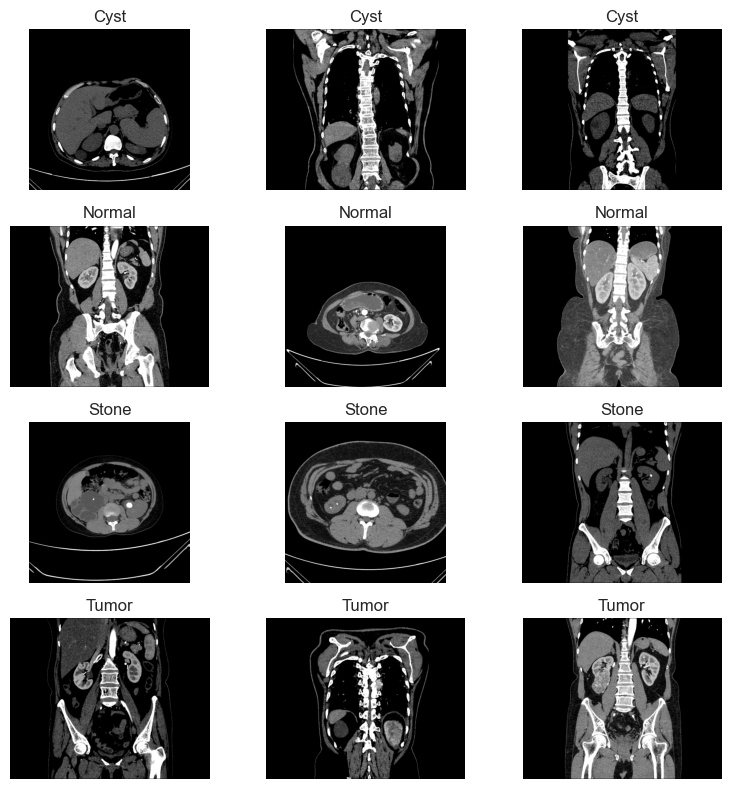

In [18]:
fig, axes = plt.subplots(4, 3, figsize=(8, 8))  
axes = axes.flatten()  

for i, label in enumerate(classes):
    class_data = df[df['label'] == label]
    sample_images = random.sample(list(class_data['file_path']), 3)
    
    for j, img_path in enumerate(sample_images):
        img = mpimg.imread(img_path) 
        axes[i * 3 + j].imshow(img)  
        axes[i * 3 + j].axis('off')  
        axes[i * 3 + j].set_title(label)  
plt.tight_layout()
plt.show()

In [19]:
 # Red channel

In [20]:
random_sample_row = df.sample(n=1)
image_path = random_sample_row['file_path'].values[0]

# image = cv2.imread(image_path)
image = plt.imread(image_path)

if np.all(image[:, :, 0] == image[:, :, 1]) and np.all(image[:, :, 1] == image[:, :, 2]):
    print("Image is black and white (3 channel grayscale).")
    print("Get or convert image to grayscale :)")
else:
    print("Image is color (RGB).")
    print("Image is really rgb dude I checked :')")

Image is black and white (3 channel grayscale).
Get or convert image to grayscale :)


The dimensions of the image are 512 pixels width and 512 pixels height, with 3 color channels.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 42.5465 and the standard deviation is 62.0637


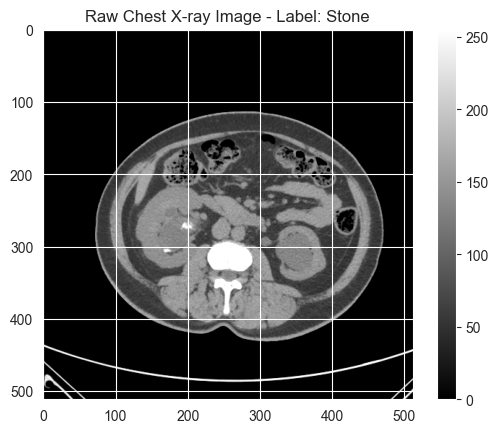

In [21]:
random_sample_row = df.sample(n=1)

image_path = random_sample_row['file_path'].values[0]
label = random_sample_row['label'].values[0]

sample_img = plt.imread(image_path)
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title(f'Raw Chest X-ray Image - Label: {label}')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, with {sample_img.shape[2]} color channels.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

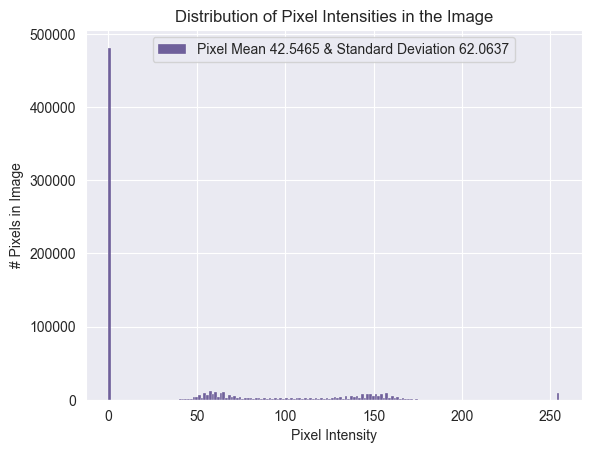

In [22]:
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

# Replace inf with NaN
sample_img = np.where(np.isinf(sample_img), np.nan, sample_img)

# Plotting code (without the deprecated option)
sns.histplot(sample_img.ravel(),
             label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}",
             kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()

In [23]:
df['binary_label'] = df['label'].apply(lambda x: "NORMAL" if x == 'Normal' else "ABNORMAL")

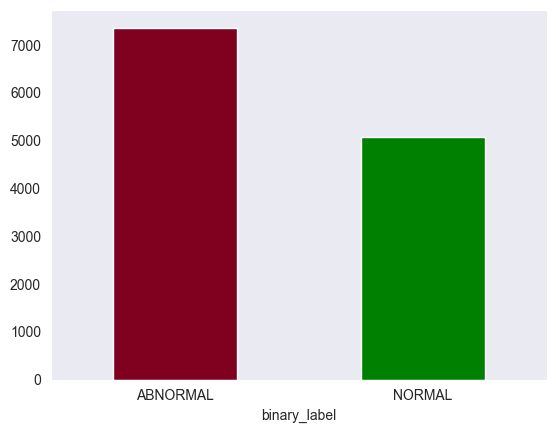

In [24]:
value_counts = df['binary_label'].value_counts()
ax = value_counts.plot(kind='bar', color=['#800020', 'green'])
plt.xticks(rotation=360)
plt.grid(False)

plt.show()

#PREPROCESSING

In [25]:
df["binary_label"] = df["label"].apply(lambda x: 0 if x == "Normal" else 1)

In [26]:
label_mapping = {"Normal" : 0, "Cyst": 1 , "Tumor": 2, "Stone": 3}
df["label"] = df["label"].map(label_mapping)


In [27]:
df

,file_path,label,binary_label
0,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
1,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
2,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
3,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
4,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
...,...,...,...
12441,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,2,1
12442,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,2,1
12443,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,2,1
12444,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,2,1


In [28]:
df['label'].value_counts()

label
0    5077
1    3709
2    2283
3    1377
Name: count, dtype: int64

In [29]:
train_df , temp_df = train_test_split(df, test_size = 0.3, random_state = 42, stratify = df["label"])
test_df, valid_df = train_test_split(temp_df, test_size = 0.3, random_state=42, stratify = temp_df["label"])

print("Training set shapes:",train_df.shape)
print("Training set shapes:",test_df.shape)
print("Training set shapes:",valid_df.shape)

Training set shapes: (8712, 3)
Training set shapes: (2613, 3)
Training set shapes: (1121, 3)


In [30]:
df

,file_path,label,binary_label
0,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
1,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
2,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
3,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
4,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
...,...,...,...
12441,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,2,1
12442,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,2,1
12443,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,2,1
12444,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,2,1


In [31]:
print("\nTraining Set class Distribution:")
print(train_df["label"].value_counts(normalize = True))
print(train_df["binary_label"].value_counts(normalize = True))

print("\nTesting Set class Distribution:")
print(test_df["label"].value_counts(normalize = True))
print(test_df["binary_label"].value_counts(normalize = True))

print("\nvalidation Set class Distribution:")
print(valid_df["label"].value_counts(normalize = True))
print(valid_df["binary_label"].value_counts(normalize = True))




Training Set class Distribution:
label
0    0.407943
1    0.297980
2    0.183425
3    0.110652
Name: proportion, dtype: float64
binary_label
1    0.592057
0    0.407943
Name: proportion, dtype: float64

Testing Set class Distribution:
label
0    0.407960
1    0.298125
2    0.183314
3    0.110601
Name: proportion, dtype: float64
binary_label
1    0.59204
0    0.40796
Name: proportion, dtype: float64

validation Set class Distribution:
label
0    0.407672
1    0.297948
2    0.183764
3    0.110616
Name: proportion, dtype: float64
binary_label
1    0.592328
0    0.407672
Name: proportion, dtype: float64


In [32]:
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

train_df['binary_label'] = train_df['binary_label'].astype(str)
test_df['binary_label'] = test_df['binary_label'].astype(str)
valid_df['binary_label'] = valid_df['binary_label'].astype(str)

In [33]:
aug_image_generator = ImageDataGenerator(
    rescale=1.0/255,  
    rotation_range=10, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.1,  
    zoom_range=0.1, 
    horizontal_flip=True,  
    fill_mode='nearest',  
)
ori_image_generator = ImageDataGenerator(
    rescale = 1.0/255
)

In [34]:
aug_training_set = aug_image_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = "file_path",
    y_col = "label",
    target_size = (224,224),
    batch_size=32,
    class_mode='categorical', 
    color_mode='grayscale',
    shuffle=True,
    seed = 42
)
ori_training_set = ori_image_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = "file_path",
    y_col = "label",
    target_size = (224,224),
    batch_size=32,
    class_mode='categorical', 
    color_mode='grayscale',
    shuffle=True,
    seed = 42
)

Found 8712 validated image filenames belonging to 4 classes.
Found 8712 validated image filenames belonging to 4 classes.


In [35]:
def combined_generator(aug_training_set, ori_training_set):
    n_orig = int(0.5 * len(aug_training_set))
    n_aug = len(aug_training_set) - n_orig
    
    while True:
        aug_images, aug_labels = next(aug_training_set)
        orig_images, orig_labels = next(ori_training_set)
        
        combined_images = np.concatenate((orig_images[:n_orig], aug_images[n_aug:]), axis=0)
        combined_labels = np.concatenate((orig_labels[:n_orig], aug_labels[n_aug:]), axis=0)
        
        yield combined_images, combined_labels
    

In [36]:
training_set = combined_generator(aug_training_set, ori_training_set)
training_set

<generator object combined_generator at 0x000002DBAF0A3900>

In [37]:
validation_set = ori_image_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='file_path', 
    y_col='label',
    target_size=(224, 224), 
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical', 
    shuffle=False  
)

Found 1121 validated image filenames belonging to 4 classes.


In [38]:
validation_set

In [39]:
test_set = ori_image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path', 
    y_col='label',  
    target_size=(224, 224),  
    color_mode='grayscale', 
    batch_size=32,  
    class_mode='categorical', 
    shuffle=False  
)

Found 2613 validated image filenames belonging to 4 classes.


In [40]:
print("Training set class distribution:")
print(ori_training_set.class_indices)
print(ori_training_set.classes[:20])
print(ori_training_set.samples)

print("\nTesting set class distribution:")
print(test_set.class_indices)
print(test_set.classes[0:20])
print(test_set.samples) 

print("\nValidation set class distribution:")
print(validation_set.class_indices)
print(validation_set.classes[0:20])
print(validation_set.samples) 

Training set class distribution:
{'0': 0, '1': 1, '2': 2, '3': 3}
[2, 2, 0, 0, 1, 0, 2, 0, 2, 0, 1, 0, 3, 1, 1, 2, 0, 1, 2, 0]
8712

Testing set class distribution:
{'0': 0, '1': 1, '2': 2, '3': 3}
[0, 0, 3, 0, 1, 0, 0, 0, 2, 0, 1, 1, 1, 0, 1, 1, 0, 1, 2, 1]
2613

Validation set class distribution:
{'0': 0, '1': 1, '2': 2, '3': 3}
[2, 1, 1, 0, 2, 1, 2, 1, 0, 1, 0, 3, 0, 0, 1, 2, 0, 0, 3, 0]
1121


In [41]:
import numpy as np

unique_classes, counts = np.unique(ori_training_set.classes, return_counts=True)

for label, count in zip(unique_classes, counts):
    print(f"Class {label}: {count} images")

Class 0: 3554 images
Class 1: 2596 images
Class 2: 1598 images
Class 3: 964 images


In [43]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(ori_training_set.classes), y= ori_training_set.classes)
class_weights_dict = dict(zip(np.unique(ori_training_set.classes), class_weights))
class_weights_dict

{0: 0.6128306133933596,
 1: 0.8389830508474576,
 2: 1.362953692115144,
 3: 2.259336099585062}

In [44]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import Callback
def lr_schedule(epoch):
    initial_lr = 0.001
    drop_factor = 0.5
    drop_every = 5  
    lr = initial_lr * (drop_factor ** (epoch // drop_every))
    return lr

class CustomObjectiveLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc_val = logs.get('val_accuracy', 0)
        acc_train = logs.get('accuracy', 0)
        loss_val = logs.get('val_loss', 0)
        loss_train = logs.get('loss', 0)

        loss_diff = abs(loss_val - loss_train)
        objective_value = acc_val - loss_diff
        logs['val_objective'] = objective_value
        print(f"Epoch {epoch + 1:05d}: Custom Objective = {objective_value:.6f}")
        print(f"  Training Accuracy =   {acc_train:.6f},Training Loss  = {loss_train:.6f}")
        print(f"  Validation Accuracy = {acc_val:.6f}, Validation Loss = {loss_val:.6f}")



model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras', 
    monitor='val_objective', 
    save_best_only=True, 
    verbose=1, 
    mode='max', 
    save_freq='epoch',
    save_weights_only=False  
)


early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=20, 
    mode='max', 
    verbose=1, 
    restore_best_weights=True,
    baseline=0.99, 
    min_delta=0.001 
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    verbose=1, 
    mode='min', 
    min_delta=0.001, 
    cooldown=2, 
    min_lr=1e-6,
    #epsilon=0.001  
)

#terminate_on_nan = TerminateOnNaN()
#lr_scheduler = LearningRateScheduler(lr_schedule)
#CSVLogger('training_log.csv', append=False)


callbacks = [
    CustomObjectiveLogger(),
    early_stopping,
    reduce_lr,
    model_checkpoint,
    # lr_scheduler,
    # csv_logger,
   #  terminate_on_nan
]

In [45]:
model = Sequential()

model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(224, 224, 1)))
model.add(BatchNormalization())  
model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))  

model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())  
model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())  
model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))


model.add(GlobalAveragePooling2D())
# model.add(Flatten())  

model.add(Dense(128, activation='relu'))  
model.add(BatchNormalization())  
model.add(Dropout(0.3))  

model.add(Dense(64, activation='relu'))  
model.add(BatchNormalization()) 
model.add(Dropout(0.3)) 

model.add(Dense(32, activation='relu')) 
model.add(BatchNormalization()) 
model.add(Dropout(0.3))  

model.add(Dense(4, activation='softmax'))  # softmax

model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # categorical_crossentropy
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        

In [149]:
history = model.fit(
    training_set,
    steps_per_epoch = ori_training_set.samples // ori_training_set.batch_size, 
    epochs=50,
    validation_data = validation_set,
    callbacks=callbacks,  
    class_weight=class_weights_dict,  # Sınıf ağırlıklarını ekleyin
    verbose=1
)

Epoch 1/50
272/272 [==============================] - ETA: 0s - loss: 1.1766 - accuracy: 0.5176
Epoch 00001: val_accuracy improved from -inf to 0.29795, saving model to best_model.keras
272/272 [==============================] - 116s 361ms/step - loss: 1.1766 - accuracy: 0.5176 - val_loss: 3.6303 - val_accuracy: 0.2979 - lr: 0.0010
Epoch 2/50
272/272 [==============================] - ETA: 0s - loss: 0.7924 - accuracy: 0.6881
Epoch 00002: val_accuracy did not improve from 0.29795
272/272 [==============================] - 114s 420ms/step - loss: 0.7924 - accuracy: 0.6881 - val_loss: 3.3326 - val_accuracy: 0.1302 - lr: 0.0010
Epoch 3/50
272/272 [==============================] - ETA: 0s - loss: 0.5498 - accuracy: 0.7993
Epoch 00003: val_accuracy improved from 0.29795 to 0.47458, saving model to best_model.keras
272/272 [==============================] - 102s 376ms/step - loss: 0.5498 - accuracy: 0.7993 - val_loss: 1.6322 - val_accuracy: 0.4746 - lr: 0.0010
Epoch 4/50
272/272 [==========

In [150]:

test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test Accuracy: {test_accuracy:.5f}")
print(f"Test Loss: {test_loss:.5f}")

82/82 [==============================] - 13s 156ms/step - loss: 0.0013 - accuracy: 1.0000
Test Accuracy: 1.00000
Test Loss: 0.00129


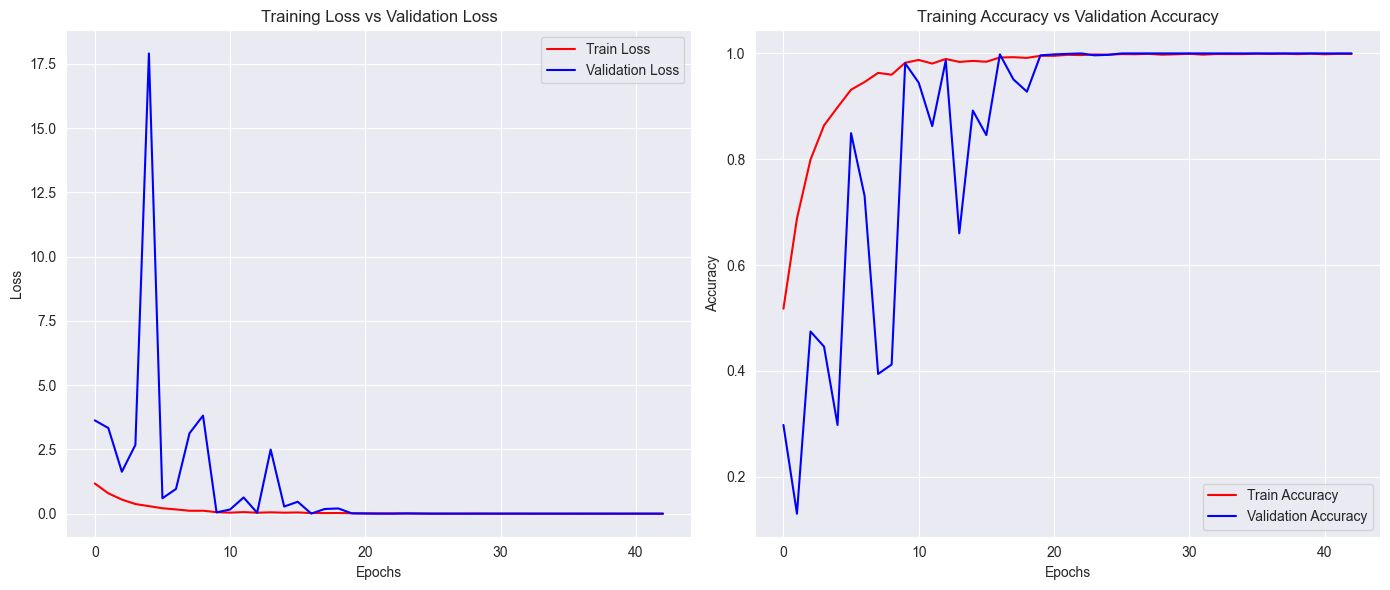

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].set_title('Training Loss vs Validation Loss')
ax[0].plot(history.history['loss'], color='red', label='Train Loss')
ax[0].plot(history.history['val_loss'], color='blue', label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].set_title('Training Accuracy vs Validation Accuracy')
ax[1].plot(history.history['accuracy'], color='red', label='Train Accuracy')
ax[1].plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()


In [153]:
model.save('aug&origi_base_training_model.keras')

In [162]:
from tensorflow.keras.preprocessing import image
model = load_model("aug&origi_base_training_model.keras")

# Define the image path
img_path = "research/CT-scan-of-the-abdomen-and-pelvis-showing-a-renal-stone-in-the-lower-pole-of-the-right.png"

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224), color_mode="grayscale")  # match your training size
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize if you used rescale=1./255 during training
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# Predict
prediction = model.predict(img_array)
pred_index = np.argmax(prediction)

In [163]:
pred_index

3

# SAME TRAINING MODEL WITH ONLY ORIGINAL TRAINING DATA WITHOUT AUGMENTATION 

In [52]:
history = model.fit(
    ori_training_set,
    steps_per_epoch = ori_training_set.samples // ori_training_set.batch_size, 
    epochs=50,
    validation_data = validation_set,
    callbacks=callbacks,  
    class_weight=class_weights_dict, 
    verbose=1
)

Epoch 1/50
272/272 [==============================] - ETA: 0s - loss: 1.0634 - accuracy: 0.5641
Epoch 00001: val_accuracy improved from -inf to 0.29795, saving model to best_model.keras
272/272 [==============================] - 60s 186ms/step - loss: 1.0634 - accuracy: 0.5641 - val_loss: 9.3168 - val_accuracy: 0.2979 - lr: 0.0010
Epoch 2/50
272/272 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.7263
Epoch 00002: val_accuracy did not improve from 0.29795
272/272 [==============================] - 50s 182ms/step - loss: 0.6962 - accuracy: 0.7263 - val_loss: 8.5545 - val_accuracy: 0.1106 - lr: 0.0010
Epoch 3/50
272/272 [==============================] - ETA: 0s - loss: 0.4909 - accuracy: 0.8218
Epoch 00003: val_accuracy did not improve from 0.29795
272/272 [==============================] - 51s 186ms/step - loss: 0.4909 - accuracy: 0.8218 - val_loss: 19.9938 - val_accuracy: 0.2971 - lr: 0.0010
Epoch 4/50
272/272 [==============================] - ETA: 0s - loss: 

In [53]:

test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test Accuracy: {test_accuracy:.5f}")
print(f"Test Loss: {test_loss:.5f}")

82/82 [==============================] - 12s 138ms/step - loss: 0.0079 - accuracy: 0.9981
Test Accuracy: 0.99809
Test Loss: 0.00789


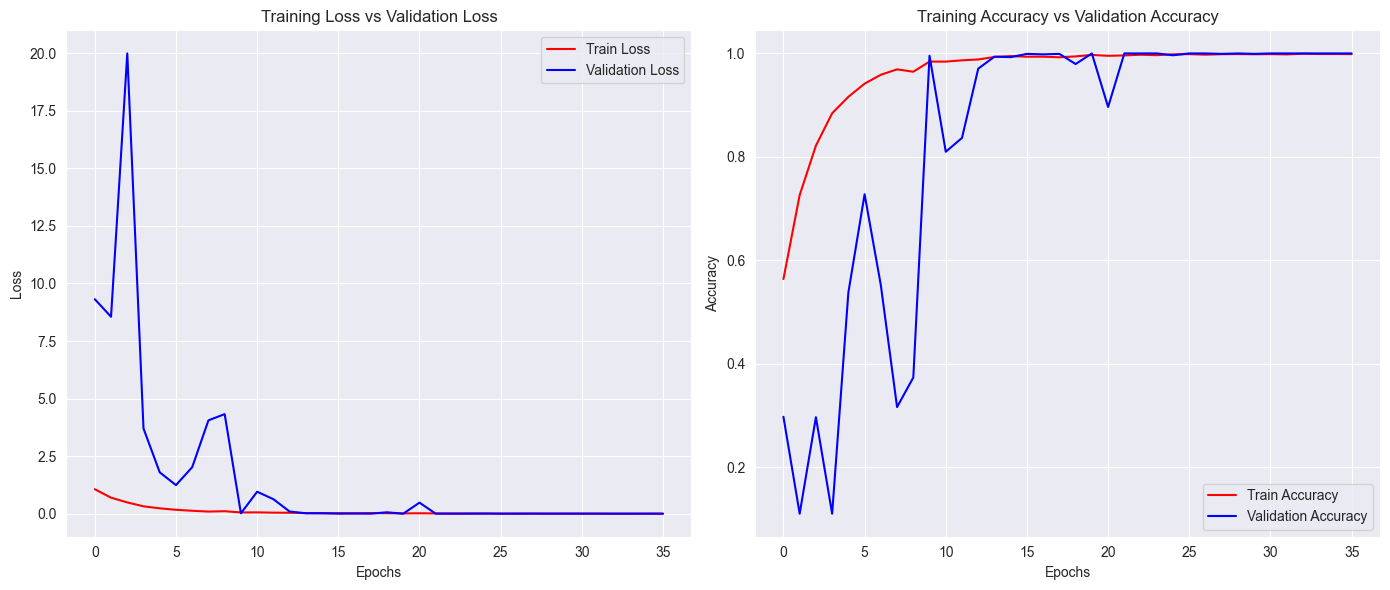

In [54]:
 fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].set_title('Training Loss vs Validation Loss')
ax[0].plot(history.history['loss'], color='red', label='Train Loss')
ax[0].plot(history.history['val_loss'], color='blue', label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].set_title('Training Accuracy vs Validation Accuracy')
ax[1].plot(history.history['accuracy'], color='red', label='Train Accuracy')
ax[1].plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()


In [55]:
model.save('only_origi_base_training_model.keras')

In [57]:
from tensorflow.keras.preprocessing import image
img_path = "research/CT-scan-of-the-abdomen-and-pelvis-showing-a-renal-stone-in-the-lower-pole-of-the-right.png"

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224), color_mode="grayscale")  # match your training size
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize if you used rescale=1./255 during training
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# Predict
prediction = model.predict(img_array)
pred_index = np.argmax(prediction)

In [58]:
pred_index

3

# SAME TRAINING MODEL WITH ONLY  AUGMENTATION  DATA WITHOUT ORIGINAL TRAINING

In [59]:
history = model.fit(
    aug_training_set,
    steps_per_epoch = ori_training_set.samples // ori_training_set.batch_size, 
    epochs=50,
    validation_data = validation_set,
    callbacks=callbacks,  
    class_weight=class_weights_dict,  # Sınıf ağırlıklarını ekleyin
    verbose=1
)

Epoch 1/50
272/272 [==============================] - ETA: 0s - loss: 0.7660 - accuracy: 0.8346
Epoch 00001: val_accuracy did not improve from 1.00000
272/272 [==============================] - 62s 225ms/step - loss: 0.7660 - accuracy: 0.8346 - val_loss: 0.1785 - val_accuracy: 0.9554 - lr: 1.5625e-05
Epoch 2/50
272/272 [==============================] - ETA: 0s - loss: 0.5069 - accuracy: 0.8719
Epoch 00002: val_accuracy did not improve from 1.00000
272/272 [==============================] - 62s 227ms/step - loss: 0.5069 - accuracy: 0.8719 - val_loss: 0.1653 - val_accuracy: 0.9572 - lr: 1.5625e-05
Epoch 3/50
272/272 [==============================] - ETA: 0s - loss: 0.4838 - accuracy: 0.8710
Epoch 00003: val_accuracy did not improve from 1.00000
272/272 [==============================] - 68s 249ms/step - loss: 0.4838 - accuracy: 0.8710 - val_loss: 0.1803 - val_accuracy: 0.9554 - lr: 1.5625e-05
Epoch 4/50
272/272 [==============================] - ETA: 0s - loss: 0.4319 - accuracy: 0.879

In [61]:

test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test Accuracy: {test_accuracy:.5f}")
print(f"Test Loss: {test_loss:.5f}")

82/82 [==============================] - 10s 122ms/step - loss: 0.2058 - accuracy: 0.9506
Test Accuracy: 0.95063
Test Loss: 0.20582


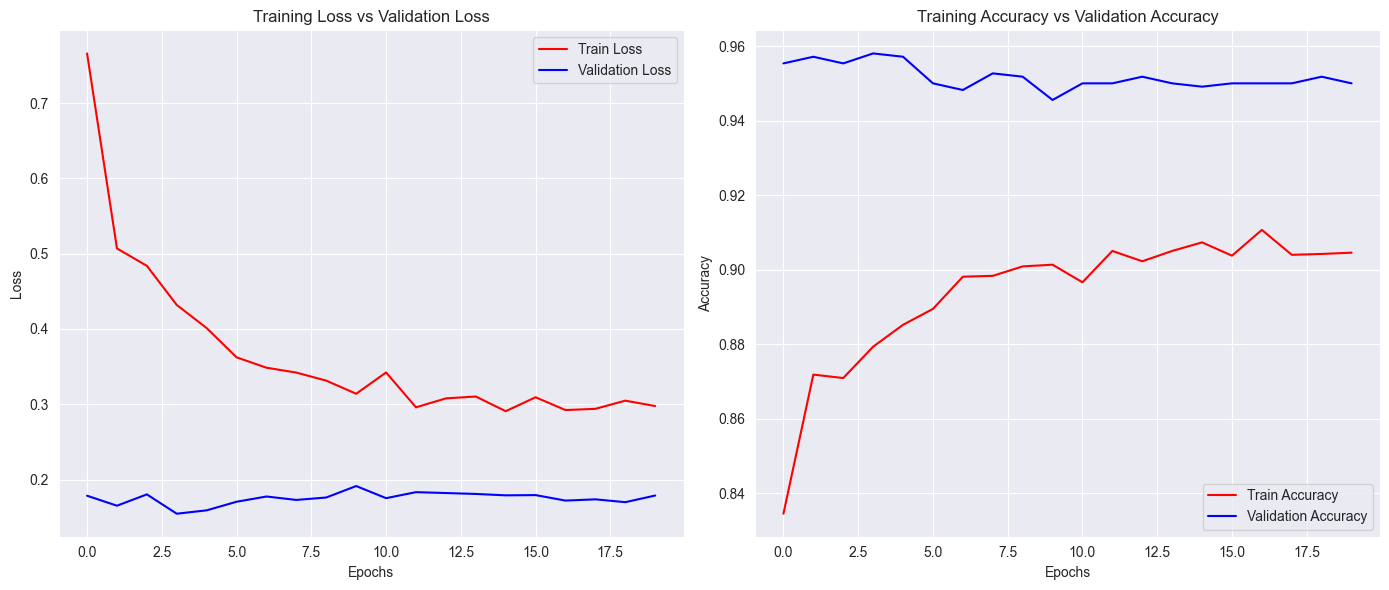

In [62]:
 fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].set_title('Training Loss vs Validation Loss')
ax[0].plot(history.history['loss'], color='red', label='Train Loss')
ax[0].plot(history.history['val_loss'], color='blue', label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].set_title('Training Accuracy vs Validation Accuracy')
ax[1].plot(history.history['accuracy'], color='red', label='Train Accuracy')
ax[1].plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()


In [46]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\DIKSHANT PATEL\Kidney-Disease-Classification\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [47]:
import optuna

In [48]:
!pip install optuna-integration
from optuna.integration import TFKerasPruningCallback

You should consider upgrading via the 'C:\Users\DIKSHANT PATEL\Kidney-Disease-Classification\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [49]:
import mlflow
import mlflow.tensorflow

In [61]:
def create_model(trial):
    n_conv_layers = trial.suggest_int("n_conv_layers",3,6)
    n_dense_layers = trial.suggest_int("n_dense_layers", 2, 5)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam','sgd'])
    strides_size = trial.suggest_categorical("strides_size",[(1, 1), (2,2)]) 
     
        # Initial filter list
    
    Allfilters = []
    
    # Add filter_0 manually if needed
    filter_0 = 32
    Allfilters.append(filter_0)
    
    if n_conv_layers == 6:
        filter6_1 = trial.suggest_categorical("filter6_1", [32, 64])
        filter6_2= 64
        filter6_3= trial.suggest_categorical("filter6_3", [64, 128])
        filter6_4= 128
        filter6_5 = 512
        Allfilters += [filter6_1, filter6_2, filter6_3, filter6_4, filter6_5]
    
    elif n_conv_layers == 5:
        filter5_1 = trial.suggest_categorical("filter5_1", [32, 64])
        filter5_2 = trial.suggest_categorical("filter5_2", [64, 128])
        filter5_3 = trial.suggest_categorical("filter5_3", [128, 512])
        filter5_4 = 512
        Allfilters += [filter5_1, filter5_2, filter5_3, filter5_4]
    
    elif n_conv_layers == 4:
        filter4_1 = trial.suggest_categorical("filter4_1", [32, 64])
        filter4_2 = 64
        filter4_3 = trial.suggest_categorical("filter4_3", [128, 512])
        Allfilters += [filter4_1, filter4_2, filter4_3]
    
    else:
        filter3_1 = trial.suggest_categorical("filter3_1", [32, 64])
        filter3_2 = trial.suggest_categorical("filter3_2", [64, 128])
        Allfilters += [filter3_1, filter3_2]
            
    
    model = Sequential()
    
    # First layer with input shape
    model.add(Conv2D(Allfilters[0], (3,3), strides=strides_size, activation='relu', padding='same', input_shape=(224, 224, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))
    
    # Remaining conv layers
    for i in range(1, n_conv_layers):
        model.add(Conv2D(Allfilters[i], (3,3), strides=strides_size, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))
                    
    model.add(GlobalAveragePooling2D()) 
    
    Alldenseunits = []

    if n_dense_layers == 5:
        dense_units5_1 = trial.suggest_categorical("dense_units5_1", [256, 128])
        dense_units5_2 = trial.suggest_categorical("dense_units5_2", [128, 64])
        dense_units5_3 = trial.suggest_categorical("dense_units5_3", [64, 32])
        dense_units5_4 = trial.suggest_categorical("dense_units5_4", [32, 10])
        Alldenseunits = [dense_units5_1, dense_units5_2, dense_units5_3, dense_units5_4]
    
    elif n_dense_layers == 4:
        dense_units4_1 = trial.suggest_categorical("dense_units4_1", [256, 128])
        dense_units4_2 = trial.suggest_categorical("dense_units4_2", [128, 64])
        dense_units4_3 = trial.suggest_categorical("dense_units4_3", [64, 32])
        Alldenseunits = [dense_units4_1, dense_units4_2, dense_units4_3]
    
    elif n_dense_layers == 3:
        dense_units3_1 = trial.suggest_categorical("dense_units3_1", [128, 64])
        dense_units3_2 = trial.suggest_categorical("dense_units3_2", [64, 32])
        Alldenseunits = [dense_units3_1, dense_units3_2]
    
    else:
        dense_units2_1 = trial.suggest_categorical("dense_units2_1", [32, 64])
        Alldenseunits = [dense_units2_1]
    
    for units in Alldenseunits:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
    
    model.add(Dense(4, activation='softmax')) 
        
    # Optimizer
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=0.01)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=0.01, momentum= 0.9, nesterov=True)
    else:
        raise ValueError("Choose 'adam' or 'sgd' for optimizer_name")

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [62]:
from mlflow.models import infer_signature
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("CNN_Optuna1_MLFLOW")

import gc
import tensorflow.keras.backend as K


def objective(trial):
    try:
        if mlflow.active_run():
           mlflow.end_run()
        input_example = np.random.rand(32, 224, 224, 1).astype(np.float32)
        output_example = np.random.rand(32, 4).astype(np.float32)
        with mlflow.start_run(run_name=f"trial_{trial.number}"):
            
            n_conv_layers = trial.suggest_int("n_conv_layers", 3, 6)
            n_dense_layers = trial.suggest_int("n_dense_layers", 2, 5)
            model = create_model(trial)
            # Log hyperparameters to MLflow
            for param_name, param_value in trial.params.items():
                mlflow.log_param(param_name, param_value)

            history = model.fit(
                training_set,
                steps_per_epoch=len(train_df) // 32,
                validation_data=validation_set,
                epochs=30,
                callbacks=callbacks,
                class_weight=class_weights_dict,
                verbose=0
            )
            # Log manually defined (static) parameters
            mlflow.log_param("image_size", "224x224x1")
            mlflow.log_param("filter_0", 32)
            mlflow.log_param("Batchsize", 32)
            mlflow.log_param("loss function" ,"categorical_crossentropy")
            
            if n_conv_layers == 6:
                mlflow.log_param("filter6_2", 64)
                mlflow.log_param("filter6_4", 128)
                mlflow.log_param("filter6_5", 512)
            if n_conv_layers == 5:
                mlflow.log_param("filter5_4", 512)
            if n_conv_layers == 4:
                mlflow.log_param("filter4_2", 64)
            if n_dense_layers == 5:
                mlflow.log_param("filter5_4", 512)
            mlflow.log_param(f"dense_units{n_dense_layers}_{n_dense_layers}", 4)   
            
            
            if np.any(np.isnan(history.history['loss'])) or np.any(np.isnan(history.history['val_loss'])):
                raise ValueError("NaN value encountered in loss or validation loss.")
            
            # Log the metrics (train and validation accuracy, loss)
            train_accuracy = max(history.history['accuracy'])  # or 'acc', depending on your Keras version
            train_loss = min(history.history['loss'])
            val_accuracy = max(history.history['val_accuracy'])
            val_loss = min(history.history['val_loss'])
            
            loss_train = history.history['loss'][-1]
            loss_val = history.history['val_loss'][-1]
            acc_val = history.history['val_accuracy'][-1]
            loss_diff = abs(loss_train - loss_val)
            objective_value = acc_val - loss_diff
           # Log metrics to MLflow
            mlflow.log_metric("train_accuracy", train_accuracy)
            mlflow.log_metric("train_loss", train_loss)
            mlflow.log_metric("val_accuracy", val_accuracy)
            mlflow.log_metric("val_loss", val_loss)
            mlflow.log_metric("acc_val - loss_diff", objective_value)
            
            signature = infer_signature(input_example, output_example)
            mlflow.tensorflow.log_model(model, artifact_path="model", signature = signature)

            return objective_value

    except Exception as e:
        print(f"[Trial Failed] Error: {e}")
        mlflow.log_param("failed_trial", True)
        mlflow.log_param("error_msg", str(e)[:500])
        return float("nan")

    finally:
        mlflow.end_run()
        try:
            del model
        except:
            pass
        K.clear_session()
        gc.collect()


In [63]:
study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler())
with mlflow.start_run(run_name="Optuna_Study_Run_Custom_CNN"):
    study.optimize(objective, n_trials=30)
    mlflow.end_run()

[I 2025-04-19 20:58:28,593] A new study created in memory with name: no-name-0f1f8a1b-0a70-4b92-aa6f-5d515ecb0d30


Epoch 00001: Custom Objective = -0.807579
  Training Accuracy =   0.601613,Training Loss  = 0.954100
  Validation Accuracy = 0.305085, Validation Loss = 2.066763

Epoch 00001: val_objective improved from -inf to -0.80758, saving model to best_model.keras
Epoch 00002: Custom Objective = 0.776937
  Training Accuracy =   0.861406,Training Loss  = 0.386755
  Validation Accuracy = 0.846566, Validation Loss = 0.456384

Epoch 00002: val_objective improved from -0.80758 to 0.77694, saving model to best_model.keras
Epoch 00003: Custom Objective = 0.762514
  Training Accuracy =   0.906567,Training Loss  = 0.277447
  Validation Accuracy = 0.975914, Validation Loss = 0.064047

Epoch 00003: val_objective did not improve from 0.77694
Epoch 00004: Custom Objective = 0.847571
  Training Accuracy =   0.933756,Training Loss  = 0.211062
  Validation Accuracy = 0.976806, Validation Loss = 0.081827

Epoch 00004: val_objective improved from 0.77694 to 0.84757, saving model to best_model.keras
Epoch 00005: C

[I 2025-04-19 21:34:39,841] Trial 0 finished with value: 0.9797567076748237 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 5, 'optimizer': 'sgd', 'strides_size': (2, 2), 'filter4_1': 64, 'filter4_3': 128, 'dense_units5_1': 256, 'dense_units5_2': 64, 'dense_units5_3': 64, 'dense_units5_4': 10}. Best is trial 0 with value: 0.9797567076748237.


Epoch 00001: Custom Objective = -0.517822
  Training Accuracy =   0.598963,Training Loss  = 1.005541
  Validation Accuracy = 0.330062, Validation Loss = 1.853425

Epoch 00001: val_objective did not improve from 0.98429
Epoch 00002: Custom Objective = 0.268793
  Training Accuracy =   0.868203,Training Loss  = 0.379524
  Validation Accuracy = 0.716325, Validation Loss = 0.827055

Epoch 00002: val_objective did not improve from 0.98429
Epoch 00003: Custom Objective = 0.923187
  Training Accuracy =   0.932604,Training Loss  = 0.221713
  Validation Accuracy = 0.925067, Validation Loss = 0.219833

Epoch 00003: val_objective did not improve from 0.98429
Epoch 00004: Custom Objective = 0.839703
  Training Accuracy =   0.943203,Training Loss  = 0.180646
  Validation Accuracy = 0.991971, Validation Loss = 0.028377

Epoch 00004: val_objective did not improve from 0.98429
Epoch 00005: Custom Objective = 0.924672
  Training Accuracy =   0.971544,Training Loss  = 0.100719
  Validation Accuracy = 0.9

[I 2025-04-19 22:13:40,363] Trial 1 finished with value: 0.9928826699178899 and parameters: {'n_conv_layers': 5, 'n_dense_layers': 5, 'optimizer': 'sgd', 'strides_size': (2, 2), 'filter5_1': 32, 'filter5_2': 128, 'filter5_3': 512, 'dense_units5_1': 256, 'dense_units5_2': 64, 'dense_units5_3': 32, 'dense_units5_4': 32}. Best is trial 1 with value: 0.9928826699178899.


Epoch 00001: Custom Objective = -10.828073
  Training Accuracy =   0.743894,Training Loss  = 0.671356
  Validation Accuracy = 0.138269, Validation Loss = 11.637698

Epoch 00001: val_objective did not improve from 0.99513
Epoch 00002: Custom Objective = -0.653360
  Training Accuracy =   0.940092,Training Loss  = 0.168508
  Validation Accuracy = 0.609277, Validation Loss = 1.431146

Epoch 00002: val_objective did not improve from 0.99513
Epoch 00003: Custom Objective = 0.011619
  Training Accuracy =   0.969585,Training Loss  = 0.097688
  Validation Accuracy = 0.730598, Validation Loss = 0.816667

Epoch 00003: val_objective did not improve from 0.99513
Epoch 00004: Custom Objective = 0.955330
  Training Accuracy =   0.975806,Training Loss  = 0.075301
  Validation Accuracy = 0.971454, Validation Loss = 0.091426

Epoch 00004: val_objective did not improve from 0.99513
Epoch 00005: Custom Objective = 0.865112
  Training Accuracy =   0.989055,Training Loss  = 0.032518
  Validation Accuracy = 

[I 2025-04-19 22:49:43,975] Trial 2 finished with value: 0.9984600452371524 and parameters: {'n_conv_layers': 3, 'n_dense_layers': 3, 'optimizer': 'sgd', 'strides_size': (2, 2), 'filter3_1': 64, 'filter3_2': 128, 'dense_units3_1': 64, 'dense_units3_2': 64}. Best is trial 2 with value: 0.9984600452371524.


Epoch 00001: Custom Objective = -6.391161
  Training Accuracy =   0.712903,Training Loss  = 0.711990
  Validation Accuracy = 0.109723, Validation Loss = 7.212875

Epoch 00001: val_objective did not improve from 0.99846
Epoch 00002: Custom Objective = -0.733292
  Training Accuracy =   0.910253,Training Loss  = 0.268062
  Validation Accuracy = 0.599465, Validation Loss = 1.600819

Epoch 00002: val_objective did not improve from 0.99846
Epoch 00003: Custom Objective = -0.577195
  Training Accuracy =   0.967166,Training Loss  = 0.099645
  Validation Accuracy = 0.652988, Validation Loss = 1.329829

Epoch 00003: val_objective did not improve from 0.99846
Epoch 00004: Custom Objective = -9.200426
  Training Accuracy =   0.971083,Training Loss  = 0.090498
  Validation Accuracy = 0.543265, Validation Loss = 9.834188

Epoch 00004: val_objective did not improve from 0.99846
Epoch 00005: Custom Objective = 0.934339
  Training Accuracy =   0.971889,Training Loss  = 0.088720
  Validation Accuracy = 

[I 2025-04-19 23:30:55,783] Trial 3 finished with value: 0.9997941214314778 and parameters: {'n_conv_layers': 5, 'n_dense_layers': 2, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter5_1': 64, 'filter5_2': 64, 'filter5_3': 128, 'dense_units2_1': 32}. Best is trial 3 with value: 0.9997941214314778.


Epoch 00001: Custom Objective = -2.948882
  Training Accuracy =   0.672581,Training Loss  = 0.862392
  Validation Accuracy = 0.231936, Validation Loss = 4.043209

Epoch 00001: val_objective did not improve from 0.99983
Epoch 00002: Custom Objective = 0.528422
  Training Accuracy =   0.902650,Training Loss  = 0.280599
  Validation Accuracy = 0.842105, Validation Loss = 0.594282

Epoch 00002: val_objective did not improve from 0.99983
Epoch 00003: Custom Objective = 0.862144
  Training Accuracy =   0.943894,Training Loss  = 0.174991
  Validation Accuracy = 0.979483, Validation Loss = 0.057652

Epoch 00003: val_objective did not improve from 0.99983
Epoch 00004: Custom Objective = 0.902171
  Training Accuracy =   0.959101,Training Loss  = 0.130093
  Validation Accuracy = 0.983943, Validation Loss = 0.048322

Epoch 00004: val_objective did not improve from 0.99983
Epoch 00005: Custom Objective = 0.928142
  Training Accuracy =   0.971659,Training Loss  = 0.093867
  Validation Accuracy = 0.9

[I 2025-04-20 00:09:44,073] Trial 4 finished with value: 0.9975851615890861 and parameters: {'n_conv_layers': 5, 'n_dense_layers': 5, 'optimizer': 'sgd', 'strides_size': (2, 2), 'filter5_1': 32, 'filter5_2': 128, 'filter5_3': 512, 'dense_units5_1': 256, 'dense_units5_2': 64, 'dense_units5_3': 64, 'dense_units5_4': 32}. Best is trial 3 with value: 0.9997941214314778.


Epoch 00001: Custom Objective = -18.069888
  Training Accuracy =   0.652189,Training Loss  = 0.878763
  Validation Accuracy = 0.110616, Validation Loss = 19.059267

Epoch 00001: val_objective did not improve from 0.99983
Epoch 00002: Custom Objective = -18.840858
  Training Accuracy =   0.814747,Training Loss  = 0.466207
  Validation Accuracy = 0.259590, Validation Loss = 19.566654

Epoch 00002: val_objective did not improve from 0.99983
Epoch 00003: Custom Objective = -6.632840
  Training Accuracy =   0.906567,Training Loss  = 0.246523
  Validation Accuracy = 0.402319, Validation Loss = 7.281682

Epoch 00003: val_objective did not improve from 0.99983
Epoch 00004: Custom Objective = -2.607739
  Training Accuracy =   0.931106,Training Loss  = 0.187591
  Validation Accuracy = 0.401427, Validation Loss = 3.196757

Epoch 00004: val_objective did not improve from 0.99983
Epoch 00005: Custom Objective = -12.886775
  Training Accuracy =   0.957949,Training Loss  = 0.116221
  Validation Accur

[I 2025-04-20 00:48:44,397] Trial 5 finished with value: 0.9987074531090911 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 3, 'optimizer': 'sgd', 'strides_size': (1, 1), 'filter4_1': 32, 'filter4_3': 512, 'dense_units3_1': 128, 'dense_units3_2': 64}. Best is trial 3 with value: 0.9997941214314778.


Epoch 00001: Custom Objective = -3.164361
  Training Accuracy =   0.802880,Training Loss  = 0.532517
  Validation Accuracy = 0.367529, Validation Loss = 4.064407

Epoch 00001: val_objective did not improve from 0.99983
Epoch 00002: Custom Objective = -1.813249
  Training Accuracy =   0.980645,Training Loss  = 0.062427
  Validation Accuracy = 0.480821, Validation Loss = 2.356497

Epoch 00002: val_objective did not improve from 0.99983
Epoch 00003: Custom Objective = 0.902046
  Training Accuracy =   0.983410,Training Loss  = 0.055854
  Validation Accuracy = 0.959857, Validation Loss = 0.113665

Epoch 00003: val_objective did not improve from 0.99983
Epoch 00004: Custom Objective = -1.142131
  Training Accuracy =   0.995277,Training Loss  = 0.016764
  Validation Accuracy = 0.624442, Validation Loss = 1.783337

Epoch 00004: val_objective did not improve from 0.99983
Epoch 00005: Custom Objective = -4.107291
  Training Accuracy =   0.985138,Training Loss  = 0.045632
  Validation Accuracy = 

[I 2025-04-20 01:23:19,157] Trial 6 finished with value: 0.9992408541820623 and parameters: {'n_conv_layers': 6, 'n_dense_layers': 2, 'optimizer': 'sgd', 'strides_size': (1, 1), 'filter6_1': 32, 'filter6_3': 64, 'dense_units2_1': 32}. Best is trial 3 with value: 0.9997941214314778.


Epoch 00001: Custom Objective = -4.658954
  Training Accuracy =   0.576152,Training Loss  = 1.019859
  Validation Accuracy = 0.110616, Validation Loss = 5.789428

Epoch 00001: val_objective did not improve from 0.99983
Epoch 00002: Custom Objective = -1.687070
  Training Accuracy =   0.701267,Training Loss  = 0.752729
  Validation Accuracy = 0.337199, Validation Loss = 2.776999

Epoch 00002: val_objective did not improve from 0.99983
Epoch 00003: Custom Objective = -14.514427
  Training Accuracy =   0.770622,Training Loss  = 0.580606
  Validation Accuracy = 0.329170, Validation Loss = 15.424203

Epoch 00003: val_objective did not improve from 0.99983
Epoch 00004: Custom Objective = -2.424346
  Training Accuracy =   0.829378,Training Loss  = 0.444185
  Validation Accuracy = 0.381802, Validation Loss = 3.250333

Epoch 00004: val_objective did not improve from 0.99983
Epoch 00005: Custom Objective = -4.773373
  Training Accuracy =   0.870507,Training Loss  = 0.334444
  Validation Accuracy

[I 2025-04-20 02:03:02,476] Trial 7 finished with value: 0.9445282407104969 and parameters: {'n_conv_layers': 3, 'n_dense_layers': 4, 'optimizer': 'sgd', 'strides_size': (1, 1), 'filter3_1': 32, 'filter3_2': 64, 'dense_units4_1': 256, 'dense_units4_2': 64, 'dense_units4_3': 32}. Best is trial 3 with value: 0.9997941214314778.


Epoch 00001: Custom Objective = -9.243757
  Training Accuracy =   0.630760,Training Loss  = 0.903043
  Validation Accuracy = 0.297948, Validation Loss = 10.444748

Epoch 00001: val_objective did not improve from 0.99983
Epoch 00002: Custom Objective = -5.302518
  Training Accuracy =   0.838594,Training Loss  = 0.436768
  Validation Accuracy = 0.378234, Validation Loss = 6.117520

Epoch 00002: val_objective did not improve from 0.99983
Epoch 00003: Custom Objective = -0.198237
  Training Accuracy =   0.919816,Training Loss  = 0.225436
  Validation Accuracy = 0.716325, Validation Loss = 1.139998

Epoch 00003: val_objective did not improve from 0.99983
Epoch 00004: Custom Objective = 0.814820
  Training Accuracy =   0.946198,Training Loss  = 0.150019
  Validation Accuracy = 0.910794, Validation Loss = 0.245993

Epoch 00004: val_objective did not improve from 0.99983
Epoch 00005: Custom Objective = 0.916292
  Training Accuracy =   0.956452,Training Loss  = 0.123771
  Validation Accuracy = 

[I 2025-04-20 02:43:26,360] Trial 8 finished with value: 0.9958152342151152 and parameters: {'n_conv_layers': 5, 'n_dense_layers': 4, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter5_1': 32, 'filter5_2': 128, 'filter5_3': 128, 'dense_units4_1': 256, 'dense_units4_2': 64, 'dense_units4_3': 64}. Best is trial 3 with value: 0.9997941214314778.


Epoch 00001: Custom Objective = -3.558164
  Training Accuracy =   0.766244,Training Loss  = 0.626409
  Validation Accuracy = 0.202498, Validation Loss = 4.387071

Epoch 00001: val_objective did not improve from 0.99983
Epoch 00002: Custom Objective = 0.286117
  Training Accuracy =   0.935253,Training Loss  = 0.179255
  Validation Accuracy = 0.740410, Validation Loss = 0.633548

Epoch 00002: val_objective did not improve from 0.99983
Epoch 00003: Custom Objective = 0.939619
  Training Accuracy =   0.969124,Training Loss  = 0.094412
  Validation Accuracy = 0.986619, Validation Loss = 0.047412

Epoch 00003: val_objective did not improve from 0.99983
Epoch 00004: Custom Objective = 0.951081
  Training Accuracy =   0.981682,Training Loss  = 0.058616
  Validation Accuracy = 0.996432, Validation Loss = 0.013265

Epoch 00004: val_objective did not improve from 0.99983
Epoch 00005: Custom Objective = 0.967137
  Training Accuracy =   0.985369,Training Loss  = 0.047220
  Validation Accuracy = 0.9

[I 2025-04-20 03:21:00,411] Trial 9 finished with value: 0.99639304538141 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'optimizer': 'sgd', 'strides_size': (2, 2), 'filter4_1': 64, 'filter4_3': 512, 'dense_units4_1': 256, 'dense_units4_2': 128, 'dense_units4_3': 32}. Best is trial 3 with value: 0.9997941214314778.


Epoch 00001: Custom Objective = -7.963929
  Training Accuracy =   0.747811,Training Loss  = 0.631501
  Validation Accuracy = 0.160571, Validation Loss = 8.756001

Epoch 00001: val_objective did not improve from 0.99983
Epoch 00002: Custom Objective = -2.769513
  Training Accuracy =   0.921198,Training Loss  = 0.206997
  Validation Accuracy = 0.357716, Validation Loss = 3.334227

Epoch 00002: val_objective did not improve from 0.99983
Epoch 00003: Custom Objective = -0.372623
  Training Accuracy =   0.964286,Training Loss  = 0.095234
  Validation Accuracy = 0.639607, Validation Loss = 1.107465

Epoch 00003: val_objective did not improve from 0.99983
Epoch 00004: Custom Objective = 0.337682
  Training Accuracy =   0.971198,Training Loss  = 0.085932
  Validation Accuracy = 0.872435, Validation Loss = 0.620685

Epoch 00004: val_objective did not improve from 0.99983
Epoch 00005: Custom Objective = 0.941071
  Training Accuracy =   0.989170,Training Loss  = 0.033284
  Validation Accuracy = 0

[I 2025-04-20 03:56:12,740] Trial 10 finished with value: 0.9999645206553396 and parameters: {'n_conv_layers': 6, 'n_dense_layers': 2, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter6_1': 64, 'filter6_3': 128, 'dense_units2_1': 64}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -10.456367
  Training Accuracy =   0.733641,Training Loss  = 0.679429
  Validation Accuracy = 0.105263, Validation Loss = 11.241058

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = -3.696037
  Training Accuracy =   0.925461,Training Loss  = 0.203339
  Validation Accuracy = 0.421945, Validation Loss = 4.321321

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = -3.298310
  Training Accuracy =   0.959447,Training Loss  = 0.116722
  Validation Accuracy = 0.414808, Validation Loss = 3.829839

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = -5.132160
  Training Accuracy =   0.983986,Training Loss  = 0.049321
  Validation Accuracy = 0.480821, Validation Loss = 5.662302

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = 0.970448
  Training Accuracy =   0.979378,Training Loss  = 0.060659
  Validation Accuracy 

[I 2025-04-20 04:37:05,610] Trial 11 finished with value: 0.9997811686412206 and parameters: {'n_conv_layers': 6, 'n_dense_layers': 2, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter6_1': 64, 'filter6_3': 128, 'dense_units2_1': 64}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -9.436674
  Training Accuracy =   0.737442,Training Loss  = 0.671426
  Validation Accuracy = 0.297948, Validation Loss = 10.406048

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = -4.146403
  Training Accuracy =   0.936406,Training Loss  = 0.192449
  Validation Accuracy = 0.236396, Validation Loss = 4.575248

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = 0.545757
  Training Accuracy =   0.974424,Training Loss  = 0.080695
  Validation Accuracy = 0.875112, Validation Loss = 0.410050

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = -3.509784
  Training Accuracy =   0.975461,Training Loss  = 0.073408
  Validation Accuracy = 0.561998, Validation Loss = 4.145190

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = -2.862353
  Training Accuracy =   0.977941,Training Loss  = 0.069713
  Validation Accuracy =

[I 2025-04-20 05:12:32,566] Trial 12 finished with value: 0.9997029011294671 and parameters: {'n_conv_layers': 6, 'n_dense_layers': 2, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter6_1': 64, 'filter6_3': 128, 'dense_units2_1': 64}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -22.222046
  Training Accuracy =   0.723387,Training Loss  = 0.692261
  Validation Accuracy = 0.297948, Validation Loss = 23.212255

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = -2.536222
  Training Accuracy =   0.905645,Training Loss  = 0.268138
  Validation Accuracy = 0.497770, Validation Loss = 3.302130

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = -1.261378
  Training Accuracy =   0.957604,Training Loss  = 0.122989
  Validation Accuracy = 0.645852, Validation Loss = 2.030219

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = 0.835419
  Training Accuracy =   0.957949,Training Loss  = 0.126937
  Validation Accuracy = 0.918822, Validation Loss = 0.210340

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = -2.495721
  Training Accuracy =   0.969700,Training Loss  = 0.092178
  Validation Accuracy 

[I 2025-04-20 05:52:16,191] Trial 13 finished with value: 0.9985672324180541 and parameters: {'n_conv_layers': 6, 'n_dense_layers': 3, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter6_1': 64, 'filter6_3': 128, 'dense_units3_1': 64, 'dense_units3_2': 32}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -11.365884
  Training Accuracy =   0.725230,Training Loss  = 0.732654
  Validation Accuracy = 0.110616, Validation Loss = 12.209153

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = -5.521931
  Training Accuracy =   0.902419,Training Loss  = 0.268050
  Validation Accuracy = 0.208742, Validation Loss = 5.998723

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = -0.290369
  Training Accuracy =   0.948848,Training Loss  = 0.146305
  Validation Accuracy = 0.697591, Validation Loss = 1.134265

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = -4.425560
  Training Accuracy =   0.969585,Training Loss  = 0.085358
  Validation Accuracy = 0.465656, Validation Loss = 4.976573

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = 0.964712
  Training Accuracy =   0.990207,Training Loss  = 0.032947
  Validation Accuracy 

[I 2025-04-20 06:33:37,948] Trial 14 finished with value: 0.9993631819372695 and parameters: {'n_conv_layers': 5, 'n_dense_layers': 2, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter5_1': 64, 'filter5_2': 64, 'filter5_3': 128, 'dense_units2_1': 32}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -8.396155
  Training Accuracy =   0.683871,Training Loss  = 0.788516
  Validation Accuracy = 0.266726, Validation Loss = 9.451397

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = -2.174720
  Training Accuracy =   0.881912,Training Loss  = 0.321119
  Validation Accuracy = 0.481713, Validation Loss = 2.977552

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = 0.916864
  Training Accuracy =   0.936060,Training Loss  = 0.195165
  Validation Accuracy = 0.928635, Validation Loss = 0.183394

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = 0.926629
  Training Accuracy =   0.961751,Training Loss  = 0.112538
  Validation Accuracy = 0.981267, Validation Loss = 0.057900

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = 0.314299
  Training Accuracy =   0.965323,Training Loss  = 0.109460
  Validation Accuracy = 0.

[I 2025-04-20 07:13:39,565] Trial 15 finished with value: 0.9992658373666927 and parameters: {'n_conv_layers': 6, 'n_dense_layers': 3, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter6_1': 32, 'filter6_3': 64, 'dense_units3_1': 128, 'dense_units3_2': 32}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -2.066971
  Training Accuracy =   0.735829,Training Loss  = 0.678696
  Validation Accuracy = 0.231936, Validation Loss = 2.977602

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = -0.082460
  Training Accuracy =   0.916244,Training Loss  = 0.230619
  Validation Accuracy = 0.746655, Validation Loss = 1.059734

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = -9.395652
  Training Accuracy =   0.951959,Training Loss  = 0.131765
  Validation Accuracy = 0.110616, Validation Loss = 9.638033

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = 0.655128
  Training Accuracy =   0.971083,Training Loss  = 0.081395
  Validation Accuracy = 0.870651, Validation Loss = 0.296918

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = -1.031031
  Training Accuracy =   0.981797,Training Loss  = 0.047579
  Validation Accuracy = 

[I 2025-04-20 07:54:41,153] Trial 16 finished with value: 0.9999311861010938 and parameters: {'n_conv_layers': 5, 'n_dense_layers': 2, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter5_1': 64, 'filter5_2': 64, 'filter5_3': 128, 'dense_units2_1': 64}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -12.803683
  Training Accuracy =   0.759332,Training Loss  = 0.620380
  Validation Accuracy = 0.294380, Validation Loss = 13.718443

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = 0.915246
  Training Accuracy =   0.926267,Training Loss  = 0.209534
  Validation Accuracy = 0.921499, Validation Loss = 0.203282

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = -0.953157
  Training Accuracy =   0.970392,Training Loss  = 0.090422
  Validation Accuracy = 0.616414, Validation Loss = 1.659993

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = -3.807903
  Training Accuracy =   0.966590,Training Loss  = 0.096651
  Validation Accuracy = 0.516503, Validation Loss = 4.421057

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = 0.981398
  Training Accuracy =   0.983871,Training Loss  = 0.048798
  Validation Accuracy =

[I 2025-04-20 08:35:46,843] Trial 17 finished with value: 0.9999229234672384 and parameters: {'n_conv_layers': 6, 'n_dense_layers': 2, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter6_1': 64, 'filter6_3': 128, 'dense_units2_1': 64}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -14.492190
  Training Accuracy =   0.685714,Training Loss  = 0.804336
  Validation Accuracy = 0.200714, Validation Loss = 15.497240

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = -11.055921
  Training Accuracy =   0.878226,Training Loss  = 0.322887
  Validation Accuracy = 0.110616, Validation Loss = 11.489424

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = -2.073589
  Training Accuracy =   0.930645,Training Loss  = 0.187143
  Validation Accuracy = 0.586084, Validation Loss = 2.846817

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = 0.490378
  Training Accuracy =   0.951959,Training Loss  = 0.149118
  Validation Accuracy = 0.835861, Validation Loss = 0.494600

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = -15.609772
  Training Accuracy =   0.970968,Training Loss  = 0.089875
  Validation Accura

[I 2025-04-20 09:15:34,994] Trial 18 finished with value: 0.9995766278784686 and parameters: {'n_conv_layers': 5, 'n_dense_layers': 3, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter5_1': 64, 'filter5_2': 64, 'filter5_3': 128, 'dense_units3_1': 128, 'dense_units3_2': 64}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -8.822149
  Training Accuracy =   0.661636,Training Loss  = 0.858417
  Validation Accuracy = 0.297056, Validation Loss = 9.977622

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = -6.750697
  Training Accuracy =   0.831567,Training Loss  = 0.453227
  Validation Accuracy = 0.148082, Validation Loss = 7.352006

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = -2.885025
  Training Accuracy =   0.903802,Training Loss  = 0.272423
  Validation Accuracy = 0.671722, Validation Loss = 3.829170

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = -1.727960
  Training Accuracy =   0.962558,Training Loss  = 0.106788
  Validation Accuracy = 0.528100, Validation Loss = 2.362848

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = -6.205569
  Training Accuracy =   0.965783,Training Loss  = 0.108276
  Validation Accuracy =

[I 2025-04-20 09:56:09,598] Trial 19 finished with value: 0.9996826086899091 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 2, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter4_1': 32, 'filter4_3': 128, 'dense_units2_1': 64}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -14.625765
  Training Accuracy =   0.700346,Training Loss  = 0.771376
  Validation Accuracy = 0.297948, Validation Loss = 15.695089

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = 0.870840
  Training Accuracy =   0.889516,Training Loss  = 0.302222
  Validation Accuracy = 0.875112, Validation Loss = 0.297951

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = 0.488177
  Training Accuracy =   0.928226,Training Loss  = 0.222633
  Validation Accuracy = 0.816235, Validation Loss = 0.550692

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = -0.501735
  Training Accuracy =   0.958064,Training Loss  = 0.123497
  Validation Accuracy = 0.672614, Validation Loss = 1.297845

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = -1.551853
  Training Accuracy =   0.959677,Training Loss  = 0.122030
  Validation Accuracy =

[I 2025-04-20 10:33:23,788] Trial 20 finished with value: 0.9991436320674438 and parameters: {'n_conv_layers': 6, 'n_dense_layers': 3, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter6_1': 64, 'filter6_3': 128, 'dense_units3_1': 64, 'dense_units3_2': 32}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -18.687618
  Training Accuracy =   0.740553,Training Loss  = 0.671827
  Validation Accuracy = 0.131133, Validation Loss = 19.490578

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = 0.360618
  Training Accuracy =   0.922696,Training Loss  = 0.213647
  Validation Accuracy = 0.793934, Validation Loss = 0.646964

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = -1.217656
  Training Accuracy =   0.964747,Training Loss  = 0.111656
  Validation Accuracy = 0.642284, Validation Loss = 1.971596

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = 0.790321
  Training Accuracy =   0.978456,Training Loss  = 0.069835
  Validation Accuracy = 0.925959, Validation Loss = 0.205473

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = -3.299891
  Training Accuracy =   0.979493,Training Loss  = 0.061693
  Validation Accuracy =

[I 2025-04-20 11:14:33,424] Trial 21 finished with value: 0.9998366719069054 and parameters: {'n_conv_layers': 6, 'n_dense_layers': 2, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter6_1': 64, 'filter6_3': 128, 'dense_units2_1': 64}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -14.986409
  Training Accuracy =   0.758756,Training Loss  = 0.630367
  Validation Accuracy = 0.295272, Validation Loss = 15.912048

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = -1.190738
  Training Accuracy =   0.941820,Training Loss  = 0.161141
  Validation Accuracy = 0.530776, Validation Loss = 1.882656

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = -0.818154
  Training Accuracy =   0.962788,Training Loss  = 0.112659
  Validation Accuracy = 0.620874, Validation Loss = 1.551687

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = -3.609760
  Training Accuracy =   0.979378,Training Loss  = 0.062541
  Validation Accuracy = 0.514719, Validation Loss = 4.187019

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = -4.233750
  Training Accuracy =   0.977074,Training Loss  = 0.067599
  Validation Accuracy

[I 2025-04-20 11:53:27,663] Trial 22 finished with value: 0.9997905403715777 and parameters: {'n_conv_layers': 6, 'n_dense_layers': 2, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter6_1': 64, 'filter6_3': 128, 'dense_units2_1': 64}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -20.515912
  Training Accuracy =   0.702650,Training Loss  = 0.748125
  Validation Accuracy = 0.297948, Validation Loss = 21.561985

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = 0.542537
  Training Accuracy =   0.903802,Training Loss  = 0.268017
  Validation Accuracy = 0.827832, Validation Loss = 0.553312

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = -5.786382
  Training Accuracy =   0.954493,Training Loss  = 0.134140
  Validation Accuracy = 0.637823, Validation Loss = 6.558345

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = -5.596761
  Training Accuracy =   0.975806,Training Loss  = 0.069000
  Validation Accuracy = 0.482605, Validation Loss = 6.148365

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = -15.682119
  Training Accuracy =   0.976498,Training Loss  = 0.074489
  Validation Accuracy

[I 2025-04-20 12:31:15,960] Trial 23 finished with value: 0.9991433233444695 and parameters: {'n_conv_layers': 5, 'n_dense_layers': 2, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter5_1': 64, 'filter5_2': 64, 'filter5_3': 128, 'dense_units2_1': 64}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -12.914912
  Training Accuracy =   0.758410,Training Loss  = 0.624290
  Validation Accuracy = 0.110616, Validation Loss = 13.649817

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = -5.321201
  Training Accuracy =   0.931912,Training Loss  = 0.188178
  Validation Accuracy = 0.188225, Validation Loss = 5.697604

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = -3.701448
  Training Accuracy =   0.964171,Training Loss  = 0.110982
  Validation Accuracy = 0.597681, Validation Loss = 4.410111

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = -17.444076
  Training Accuracy =   0.961982,Training Loss  = 0.128433
  Validation Accuracy = 0.304193, Validation Loss = 17.876701

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = -3.072551
  Training Accuracy =   0.977995,Training Loss  = 0.061198
  Validation Accura

[I 2025-04-20 13:14:18,895] Trial 24 finished with value: 0.9999552748631686 and parameters: {'n_conv_layers': 6, 'n_dense_layers': 2, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter6_1': 64, 'filter6_3': 128, 'dense_units2_1': 64}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -1.882621
  Training Accuracy =   0.682604,Training Loss  = 0.807894
  Validation Accuracy = 0.279215, Validation Loss = 2.969731

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = -3.183941
  Training Accuracy =   0.849309,Training Loss  = 0.398378
  Validation Accuracy = 0.286351, Validation Loss = 3.868671

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = -5.909594
  Training Accuracy =   0.905991,Training Loss  = 0.255772
  Validation Accuracy = 0.507583, Validation Loss = 6.672948

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = -7.551447
  Training Accuracy =   0.958410,Training Loss  = 0.129140
  Validation Accuracy = 0.394291, Validation Loss = 8.074878

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = -33.785594
 

[I 2025-04-20 13:59:35,602] Trial 25 finished with value: 0.9984073924747463 and parameters: {'n_conv_layers': 5, 'n_dense_layers': 3, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter5_1': 64, 'filter5_2': 64, 'filter5_3': 512, 'dense_units3_1': 128, 'dense_units3_2': 64}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -6.752973
  Training Accuracy =   0.825000,Training Loss  = 0.489835
  Validation Accuracy = 0.309545, Validation Loss = 7.552353

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = 0.938228
  Training Accuracy =   0.952995,Training Loss  = 0.139606
  Validation Accuracy = 0.959857, Validation Loss = 0.117978

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = 0.931576
  Training Accuracy =   0.961627,Training Loss  = 0.113546
  Validation Accuracy = 0.979483, Validation Loss = 0.065639

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = 0.884846
  Training Accuracy =   0.983180,Training Loss  = 0.054655
  Validation Accuracy = 0.958965, Validation Loss = 0.128774

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = 0.836232
  Training Accuracy =   0.974309,Training Loss  = 0.077992
  Validation Accuracy = 0.9

[I 2025-04-20 14:36:04,850] Trial 26 finished with value: 0.9993568819645589 and parameters: {'n_conv_layers': 6, 'n_dense_layers': 2, 'optimizer': 'adam', 'strides_size': (2, 2), 'filter6_1': 32, 'filter6_3': 64, 'dense_units2_1': 64}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -9.286709
  Training Accuracy =   0.682719,Training Loss  = 0.788782
  Validation Accuracy = 0.295272, Validation Loss = 10.370763

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = -2.403245
  Training Accuracy =   0.895046,Training Loss  = 0.282251
  Validation Accuracy = 0.348796, Validation Loss = 3.034292

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = 0.053158
  Training Accuracy =   0.944470,Training Loss  = 0.153366
  Validation Accuracy = 0.746655, Validation Loss = 0.846864

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = 0.284102
  Training Accuracy =   0.965323,Training Loss  = 0.103391
  Validation Accuracy = 0.864407, Validation Loss = 0.683695

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = 0.117463
  Training Accuracy =   0.970161,Training Loss  = 0.088163
  Validation Accuracy = 0

[I 2025-04-20 15:19:31,074] Trial 27 finished with value: 0.999155700873871 and parameters: {'n_conv_layers': 6, 'n_dense_layers': 3, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter6_1': 64, 'filter6_3': 128, 'dense_units3_1': 64, 'dense_units3_2': 32}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -11.203012
  Training Accuracy =   0.721659,Training Loss  = 0.681215
  Validation Accuracy = 0.122212, Validation Loss = 12.006439

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = -1.294522
  Training Accuracy =   0.919470,Training Loss  = 0.218226
  Validation Accuracy = 0.559322, Validation Loss = 2.072071

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = -2.611974
  Training Accuracy =   0.951843,Training Loss  = 0.143427
  Validation Accuracy = 0.568243, Validation Loss = 3.323644

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = -10.729783
  Training Accuracy =   0.971313,Training Loss  = 0.079546
  Validation Accuracy = 0.176628, Validation Loss = 10.985957

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = -0.599149
  Training Accuracy =   0.976728,Training Loss  = 0.079929
  Validation Accura

[I 2025-04-20 16:03:17,917] Trial 28 finished with value: 0.999783881615258 and parameters: {'n_conv_layers': 5, 'n_dense_layers': 2, 'optimizer': 'adam', 'strides_size': (1, 1), 'filter5_1': 64, 'filter5_2': 64, 'filter5_3': 128, 'dense_units2_1': 64}. Best is trial 10 with value: 0.9999645206553396.


Epoch 00001: Custom Objective = -5.661322
  Training Accuracy =   0.768088,Training Loss  = 0.605962
  Validation Accuracy = 0.269402, Validation Loss = 6.536686

Epoch 00001: val_objective did not improve from 0.99996
Epoch 00002: Custom Objective = -0.549433
  Training Accuracy =   0.951037,Training Loss  = 0.150604
  Validation Accuracy = 0.680642, Validation Loss = 1.380680

Epoch 00002: val_objective did not improve from 0.99996
Epoch 00003: Custom Objective = 0.937721
  Training Accuracy =   0.956912,Training Loss  = 0.130667
  Validation Accuracy = 0.951829, Validation Loss = 0.144775

Epoch 00003: val_objective did not improve from 0.99996
Epoch 00004: Custom Objective = 0.474617
  Training Accuracy =   0.976613,Training Loss  = 0.073223
  Validation Accuracy = 0.860839, Validation Loss = 0.459445

Epoch 00004: val_objective did not improve from 0.99996
Epoch 00005: Custom Objective = 0.972019
  Training Accuracy =   0.984101,Training Loss  = 0.053657
  Validation Accuracy = 0.

[I 2025-04-20 16:42:11,720] Trial 29 finished with value: 0.9985027717157209 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'optimizer': 'adam', 'strides_size': (2, 2), 'filter4_1': 64, 'filter4_3': 512, 'dense_units4_1': 128, 'dense_units4_2': 128, 'dense_units4_3': 64}. Best is trial 10 with value: 0.9999645206553396.


In [72]:
import gc
import tensorflow.keras.backend as K

# Delete model if defined
try:
    del model
except:
    pass

K.clear_session()
gc.collect()

100

In [50]:
# After optimization is complete
print("Number of finished trials:", len(study.trials))
print("Best trial:")
print("  Value:", study.best_trial.value)
print("  Params:", study.best_trial.params)


NameError: name 'study' is not defined

In [66]:
df = study.trials_dataframe()
df

,number,value,datetime_start,datetime_complete,duration,params_dense_units2_1,params_dense_units3_1,params_dense_units3_2,params_dense_units4_1,params_dense_units4_2,...,params_filter5_1,params_filter5_2,params_filter5_3,params_filter6_1,params_filter6_3,params_n_conv_layers,params_n_dense_layers,params_optimizer,params_strides_size,state
0,0,0.979757,2025-04-19 20:58:28.635237,2025-04-19 21:34:39.841992,0 days 00:36:11.206755,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4,5,sgd,"(2, 2)",COMPLETE
1,1,0.992883,2025-04-19 21:34:39.841992,2025-04-19 22:13:40.363468,0 days 00:39:00.521476,NaN,NaN,NaN,NaN,NaN,...,32.0,128.0,512.0,NaN,NaN,5,5,sgd,"(2, 2)",COMPLETE
2,2,0.998460,2025-04-19 22:13:40.363468,2025-04-19 22:49:43.975163,0 days 00:36:03.611695,NaN,64.0,64.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3,3,sgd,"(2, 2)",COMPLETE
3,3,0.999794,2025-04-19 22:49:43.975163,2025-04-19 23:30:55.783515,0 days 00:41:11.808352,32.0,NaN,NaN,NaN,NaN,...,64.0,64.0,128.0,NaN,NaN,5,2,adam,"(1, 1)",COMPLETE
4,4,0.997585,2025-04-19 23:30:55.783515,2025-04-20 00:09:44.073239,0 days 00:38:48.289724,NaN,NaN,NaN,NaN,NaN,...,32.0,128.0,512.0,NaN,NaN,5,5,sgd,"(2, 2)",COMPLETE
5,5,0.998707,2025-04-20 00:09:44.073239,2025-04-20 00:48:44.397787,0 days 00:39:00.324548,NaN,128.0,64.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4,3,sgd,"(1, 1)",COMPLETE
6,6,0.999241,2025-04-20 00:48:44.397787,2025-04-20 01:23:19.157058,0 days 00:34:34.759271,32.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,32.0,64.0,6,2,sgd,"(1, 1)",COMPLETE
7,7,0.944528,2025-04-20 01:23:19.157058,2025-04-20 02:03:02.476219,0 days 00:39:43.319161,NaN,NaN,NaN,256.0,64.0,...,NaN,NaN,NaN,NaN,NaN,3,4,sgd,"(1, 1)",COMPLETE
8,8,0.995815,2025-04-20 02:03:02.476219,2025-04-20 02:43:26.360896,0 days 00:40:23.884677,NaN,NaN,NaN,256.0,64.0,...,32.0,128.0,128.0,NaN,NaN,5,4,adam,"(1, 1)",COMPLETE
9,9,0.996393,2025-04-20 02:43:26.360896,2025-04-20 03:21:00.411168,0 days 00:37:34.050272,NaN,NaN,NaN,256.0,128.0,...,NaN,NaN,NaN,NaN,NaN,4,4,sgd,"(2, 2)",COMPLETE


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

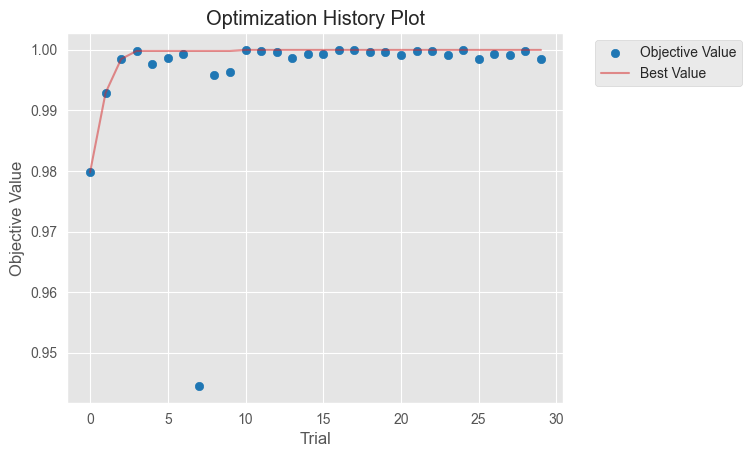

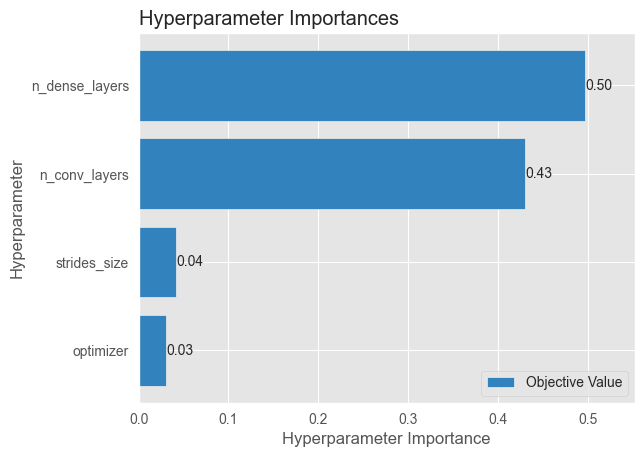

In [80]:
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

plot_optimization_history(study)
plot_param_importances(study)

In [81]:
import pandas as pd

df = study.trials_dataframe()
print(df.head())

   number     value             datetime_start          datetime_complete  \
0       0  0.979757 2025-04-19 20:58:28.635237 2025-04-19 21:34:39.841992   
1       1  0.992883 2025-04-19 21:34:39.841992 2025-04-19 22:13:40.363468   
2       2  0.998460 2025-04-19 22:13:40.363468 2025-04-19 22:49:43.975163   
3       3  0.999794 2025-04-19 22:49:43.975163 2025-04-19 23:30:55.783515   
4       4  0.997585 2025-04-19 23:30:55.783515 2025-04-20 00:09:44.073239   

                duration  params_dense_units2_1  params_dense_units3_1  \
0 0 days 00:36:11.206755                    NaN                    NaN   
1 0 days 00:39:00.521476                    NaN                    NaN   
2 0 days 00:36:03.611695                    NaN                   64.0   
3 0 days 00:41:11.808352                   32.0                    NaN   
4 0 days 00:38:48.289724                    NaN                    NaN   

   params_dense_units3_2  params_dense_units4_1  params_dense_units4_2  ...  \
0            

In [51]:
final_model = load_model("best_model.keras")
final_model

In [54]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        

In [88]:
# Test verisi üzerinde değerlendirme
test_loss, test_accuracy = final_model.evaluate(test_set)
print(f"Test Accuracy: {test_accuracy:.5f}")
print(f"Test Loss: {test_loss:.5f}")

82/82 [==============================] - 17s 182ms/step - loss: 0.0021 - accuracy: 1.0000
Test Accuracy: 1.00000
Test Loss: 0.00213


In [52]:
from tensorflow.keras.preprocessing import image

# Define the image path
img_path = "research/CT-scan-of-the-abdomen-and-pelvis-showing-a-renal-stone-in-the-lower-pole-of-the-right.png"

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224), color_mode="grayscale")  # match your training size
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize if you used rescale=1./255 during training
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# Predict
prediction = final_model.predict(img_array)
pred_index = np.argmax(prediction)

In [53]:
pred_index

3